In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;) </style>"))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import softmax
import random
import pickle
from datetime import datetime
from collections import Counter

from tqdm import tqdm

from env_mp_simple import MetaGamesLimitedtraj
from rmax_1_batch_limitedtraj import RmaxAgentTraj, Memory

def discretize(number, radius):
    #[0,3,5,4,8] --> [0,3,6,3,9] for radius 3
    return np.round(np.divide(number, radius)) * radius

def Boltzmann(arr):
    #0.5 is just a temperature parameter, controls the spread of the softmax distribution
    #action_value = np.zeros(arr.shape[0])
    prob = softmax(arr/0.2)
    action_value = np.random.choice(len(arr), p=prob)
    return action_value

inner_gamma = 0         #inner game discount factor, 0 since it's a one shot game
meta_gamma = 0.8         #meta game discount factor

R_max = 1
meta_steps = 10

game = "MP"
epsilon = 0.5

plot_rew = [0]*5
plot_visit = [0]*5

#FOR SAMPLE COMPLEXITY PLOTS
y = [0]*5                  
mean = [0]*5
convolve = [0]*5

# #FOR STUDYING POLICY, [epi, start/end, step, agent]
# Q_forplot = np.zeros((3,10,10,2))
# act_forplot = np.zeros((3,10,10,2))
for seed in range(1):
    i=2
    hist_step= i+2
    #seed = 0
    # creating environment
    env = MetaGamesLimitedtraj(hist_step, meta_steps, game)

    # creating rmax agent
    memory = Memory()
    rmax = RmaxAgentTraj(R_max, meta_steps+1, meta_gamma, inner_gamma, epsilon, hist_step)

    meta_epi = int(5 * rmax.m *rmax.ns)

    #reward tensor for plotting purposes [episode, step, agents]
    plot_rew[seed] = np.zeros((meta_epi, meta_steps, 2))
    #visited states vs reward array, [number of s-a pairs, 2], 1 for cumulative reward, 1 for number of visitation
    plot_visit[seed] = np.zeros((rmax.ns * rmax.na + 1, 2))    

    for episode in tqdm(range(meta_epi)): #for each meta-episode
        #reset environment 
        #initialise meta-state and meta-action randomly
        meta_s = env.reset()
        Q = rmax.Q

        for step in range(meta_steps):    #for each meta time step
            #--------------------------------------START OF INNER GAME--------------------------------------  
            #select our inner-action with Boltzmann sampling, oppo inner-action with epsilon greedy 
            our_action = Boltzmann(Q[rmax.find_meta_index(meta_s, "s").astype(int), :])

            #run inner game according to actions
            obs, reward, info, oppo_act = env.step(our_action)
            memory.states[i].append(obs)
            #---------------------------------------END OF INNER GAME--------------------------------------
            #save reward, info for plotting              
            plot_rew[seed][episode,step,0] = reward
            plot_rew[seed][episode,step,1] = info

            #meta-action = action that corresponds to max Q(meta_s) = our inner Q
            meta_a = our_action

            #meta-state = discretized inner game Q table of all agents
            new_meta_s = obs

            #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
            our_REW = reward    
            memory.rewards.append(our_REW)

            #rmax update step
            rmax.update(memory, meta_s, meta_a, new_meta_s)

            plot_visit[seed][(rmax.nSA >= rmax.m).sum(), 0] += reward
            plot_visit[seed][(rmax.nSA >= rmax.m).sum(), 1] += 1
            #prepare meta_s for next step
            meta_s = new_meta_s

 14%|███▉                        | 7456627/52737280 [2:48:03<9:43:03, 1294.35it/s]

In [77]:
for i in range(5):
    mean[i] = np.mean(plot_rew[i][:,:,0], axis=1)
    y[i] = np.convolve(mean[i], np.ones(int((len(plot_rew[i])/1200))) / (len(plot_rew[i])/1200), mode='valid')
y3 = y

In [81]:
y4 = pickle.load(open("plot_rew_y4_seed1.pkl", "rb"))
mean4 = np.mean(y4[0][:,:,0], axis=1)
y4 = np.convolve(mean4, np.ones(int((len(y4[0])/1600))) / (len(y4[0])/1600), mode='valid')


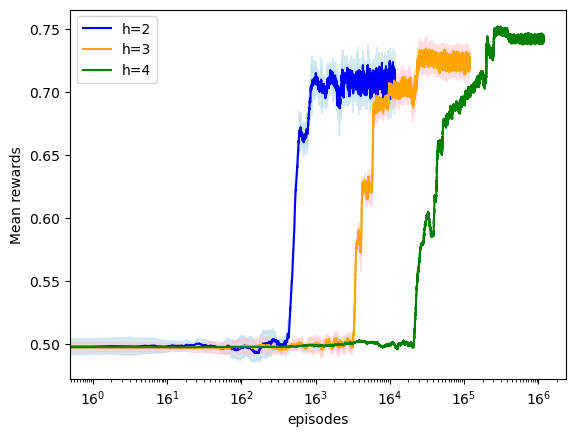

<Figure size 640x480 with 0 Axes>

In [84]:
mean_rewards2 = np.mean(y2, axis=0)
std_rewards2 = np.std(y2, axis=0)

mean_rewards3 = np.mean(y3, axis=0)
std_rewards3 = np.std(y3, axis=0)

# Plot the mean line and shaded deviation area
x2 = np.arange(mean_rewards2.shape[0])
x3 = np.arange(mean_rewards3.shape[0])
x4 = np.arange(y4.shape[0])
plt.plot(x2, mean_rewards2, color='blue', label='h=2')
plt.plot(x3, mean_rewards3, color='orange', label='h=3')
plt.fill_between(x2, mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2, color='lightblue', alpha=0.5)
plt.fill_between(x3, mean_rewards3 - std_rewards3, mean_rewards3 + std_rewards3, color='pink', alpha=0.5)

plt.plot(x4, y4, color='green', label='h=4')
plt.xscale('log',base=16) 
#reward at batch 0 only
plt.xlabel("episodes")
plt.ylabel("Mean rewards")
plt.legend()

figure_obj = plt.figure()
pickle.dump(figure_obj, open('graph_eps0.5.pickle', 'wb'))


In [ ]:
# Visitation vs Reward curve
plt.clf()

plt.plot(y[0], label='2 timesteps', lw=2)
plt.plot(y[1], label='3 timesteps',lw=2)
plt.plot(y[2], label='4 timesteps', lw=2)

plt.xlabel("m-visited state-action pairs out of " + str(rmax.ns * rmax.na))
plt.ylabel("Mean rewards")
plt.legend()

plt.savefig('visitation_all@eps' + str(epsilon) +'.png', bbox_inches='tight')


# In[171]:
#MA(metaepi/10)reward 
plt.clf()

plt.plot(convolve[0], label="2 timesteps", lw=2)
plt.plot(convolve[1], label="3 timesteps",lw=2)
plt.plot(convolve[2], label="4 timesteps", lw=2)

plt.xscale('log',base=16) 
#reward at batch 0 only
plt.xlabel("episodes \n meta_gamma= " + str(meta_gamma) + " epsilon=" + str(epsilon))
plt.ylabel("Mean rewards")

plt.legend()
plt.savefig('rewardVSepisode@eps' + str(epsilon) + '.png', bbox_inches='tight')

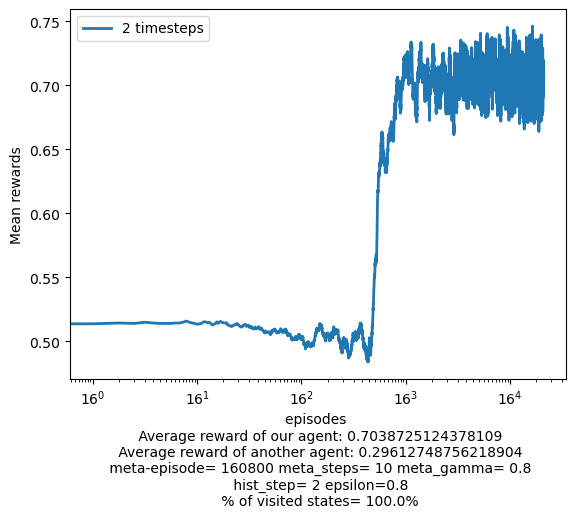

In [76]:
i=0
trial = np.convolve(mean[i], np.ones(int((len(plot_rew[i])/500))) / (len(plot_rew[i])/500), mode='valid')

plt.plot(trial, label= str(i+2) + " timesteps", lw=2)
plt.xscale('log',base=16) 
#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew[i][:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[i][:,:,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + 
          "\n hist_step= " + str(hist_step)+ " epsilon=" + str(epsilon) +
          "\n % of visited states= " + str(round(100 * (rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[0] * rmax.nSA.shape[1]),3)) + "%")
plt.ylabel("Mean rewards")
plt.legend()

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the states
states = [bin(i)[2:].zfill(6) for i in range(64)]

# Define the transitions between states as a list of tuples
transitions = []
for i in range(len(memory.states[1]) - 1):
    if i%10 != 9:
        transitions.append([memory.states[1][i], memory.states[1][i+1]])

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add the states to the graph
G.add_nodes_from(states)

trans_trial = np.empty((len(transitions),2)).astype(str)

for i in range(len(transitions)):
    trans_trial[i][0] = ''.join(str(x) for x in transitions[i][0])
    trans_trial[i][1] = ''.join(str(x) for x in transitions[i][1])

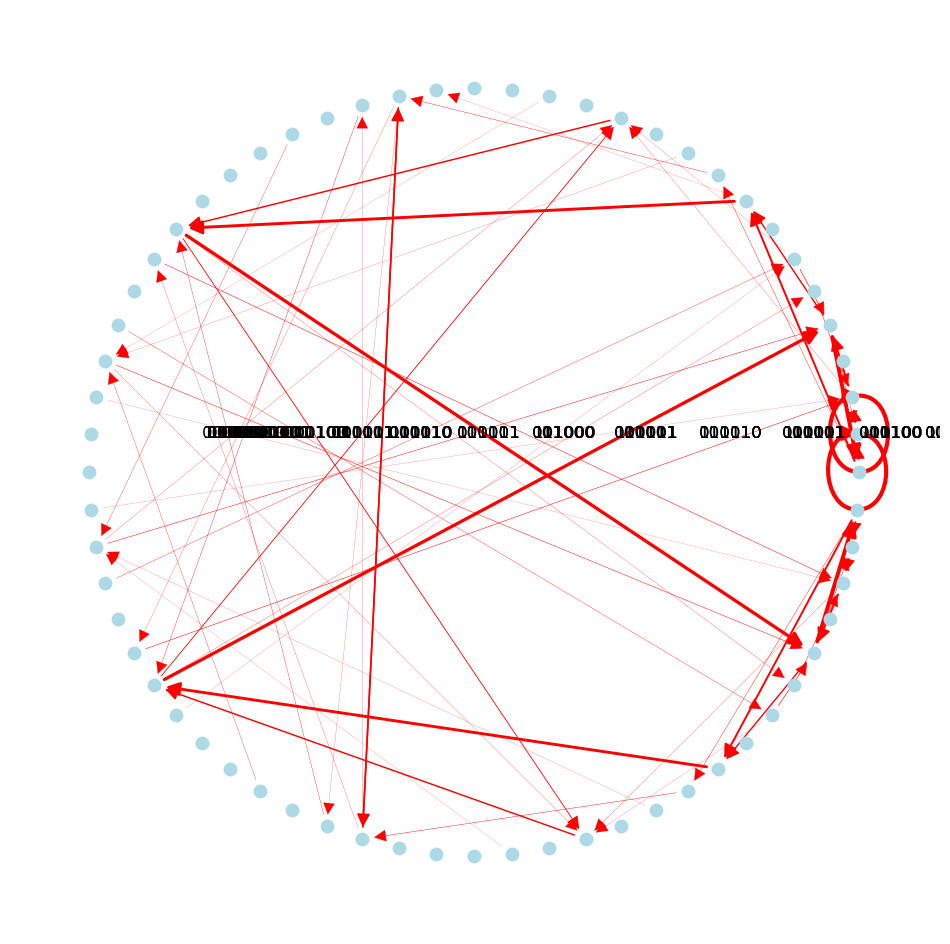

In [61]:
freq_transitions = Counter(map(tuple, trans_trial))

# Get the most frequent transitions
num_most_frequent = 64
most_freq_transitions = freq_transitions.most_common(num_most_frequent)
# Extract the edges of the most frequent transitions
most_freq_edges = [k for k, v in most_freq_transitions]

max_count = max(freq_transitions.values())

# Calculate the edge weights based on the frequency of each transition
edge_weights = {((str(u), str(v))): 3 * freq_transitions[(u, v)] / max_count for u, v in most_freq_edges}

# Set the positions of the nodes
# pos = nx.spring_layout(G, k=5000, iterations=10)
r = 2
pos = nx.circular_layout(G,r)

# Define the positions for the node labels
label_pos = {}
for node, coords in pos.items():
    radius = r + 1.0
    theta = coords[0]
    x = radius * math.cos(theta)
    y = 0  # keep labels horizontal
    label_pos[node] = (x, y + 0.2)  # increase x to move labels further out

# Draw the graph with node labels
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=80)
nx.draw_networkx_edges(G, pos, edge_color='red', edgelist=most_freq_edges, width=[edge_weights[(str(u), str(v))] for u, v in most_freq_edges], arrowsize=20)
nx.draw_networkx_labels(G, label_pos, font_size=12, font_family='sans-serif')

# Show the plot
plt.axis('off')
plt.show()

In [ ]:
freq_transitions = Counter(map(tuple, trans_trial))

# Get the most frequent transitions
num_most_frequent = 64
most_freq_transitions = freq_transitions.most_common(num_most_frequent)
# Extract the edges of the most frequent transitions
most_freq_edges = [k for k, v in most_freq_transitions]

max_count = max(freq_transitions.values())

# Calculate the edge weights based on the frequency of each transition
edge_weights = {((str(u), str(v))): 0.3 * freq_transitions[(u, v)] / max_count for u, v in most_freq_edges}

# Set the positions of the nodes
# pos = nx.spring_layout(G, k=5000, iterations=10)
r = 600
pos = nx.circular_layout(G, scale=r)

label_pos = {}
angle = 2 * np.pi / len(states)
for i, node in enumerate(states):
    theta = 360 *i / len(states)
    label_pos[node] = (r + 80, theta)

# Draw the graph with node labels
plt.figure(figsize=(16, 16))  # Set the figure size to 8x8 inches

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='red', edgelist=most_freq_edges, width=[15*edge_weights[(str(u), str(v))] for u, v in most_freq_edges], arrowsize=20)
for node, pos in label_pos.items():
    if pos[1] > 90 and pos[1] < 270:
        plt.text(pos[0] * np.cos(pos[1] * np.pi / 180), pos[0] * np.sin(pos[1] * np.pi / 180), node, rotation=pos[1]+180, fontsize=15, ha='center', va='center')
    else:
        plt.text(pos[0] * np.cos(pos[1] * np.pi / 180), pos[0] * np.sin(pos[1] * np.pi / 180), node, rotation=pos[1], fontsize=15, ha='center', va='center')

plt.axis('off')
plt.show()


# # Draw the graph with edge widths proportional to transition frequency
# nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=100)
# nx.draw_networkx_edges(G, pos, edge_color='red', edgelist=most_freq_edges, width=[5*edge_weights[(str(u), str(v))] for u, v in most_freq_edges], arrowsize=60)
# nx.draw_networkx_labels(G, pos, font_size=45, font_family='sans-serif')

# # Show the plot
# plt.axis('off')
# plt.show()

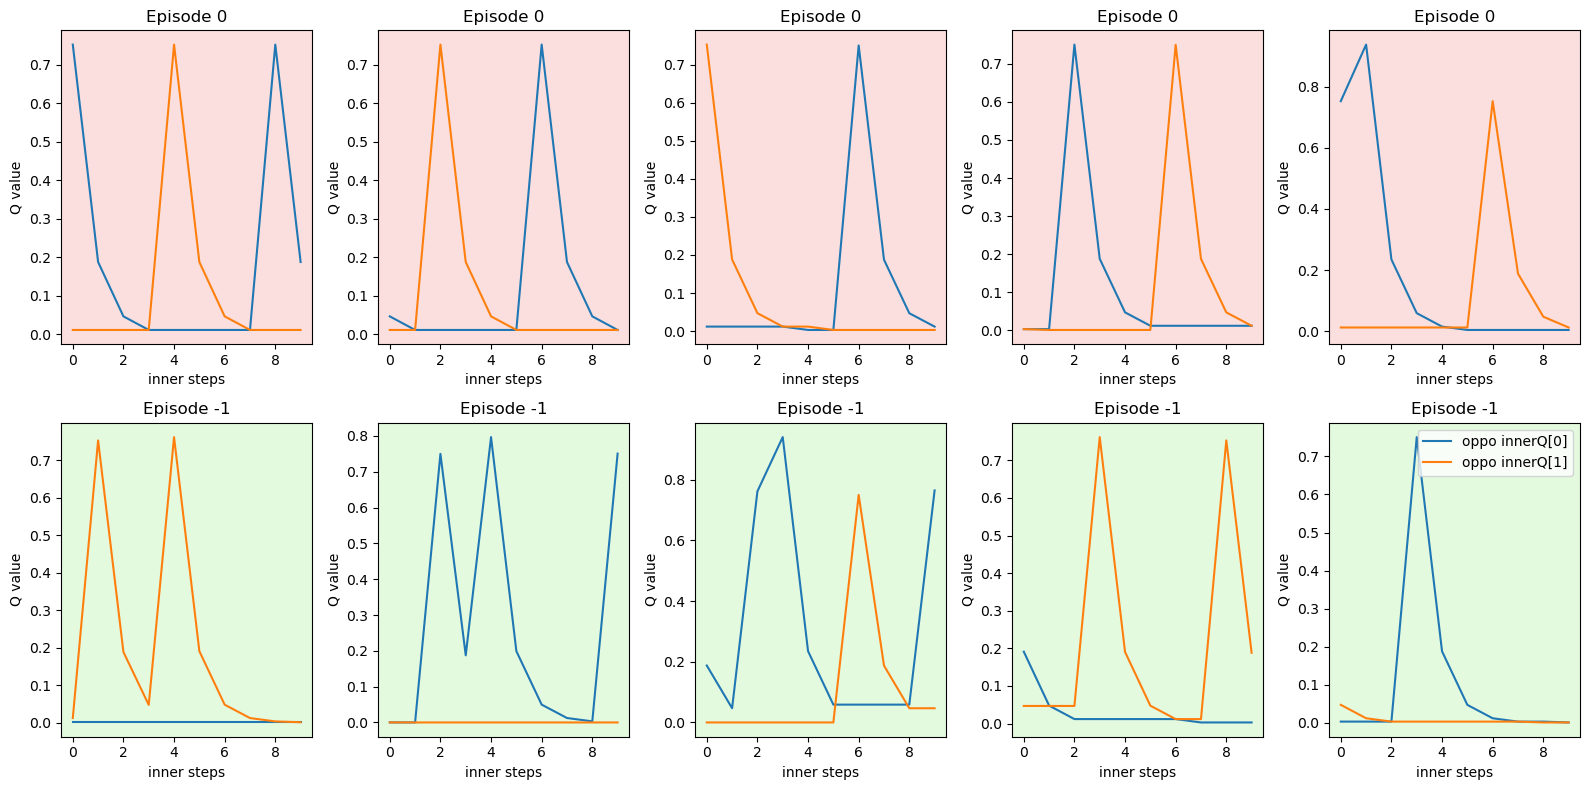

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.gridspec as gridspec

cols = ['Episode {}'.format(col) for col in [0,1,2,3,4, -5, -4, -3, -2, -1]]
rows = ["Q-value", "Q-value"]

#fig, axs = plt.subplots(2, 5, figsize=(16, 8))
fig, axs = plt.subplots(2, 5, figsize=(16, 8))

row_color = [(247/255, 203/255, 200/255, 0.6) ,(210/255, 247/255, 200/255, 0.6)]  # default color

plt.setp(axs.flat, xlabel='inner steps', ylabel='Q value')

for j in range(5):
    axs[0,j].plot(Q_forplot[0,j,:,0], label='oppo innerQ[0]')
    axs[0,j].plot(Q_forplot[0,j,:,1], label='oppo innerQ[1]')
    axs[0,j].set_facecolor(row_color[0])
    axs[1,j-5].plot(Q_forplot[0,j-5,:,0], label='oppo innerQ[0]')
    axs[1,j-5].plot(Q_forplot[0,j-5,:,1], label='oppo innerQ[1]')
    axs[1,j-5].set_facecolor(row_color[1])
    axs[0,j].set_title(cols[0])
    axs[1,j-5].set_title(cols[-1])
#for ax, row in zip(axs, rows):
#    plt.set_ylabel(row, rotation='vertical', size='large')
    
fig.tight_layout()
plt.legend()
plt.show()
plt.savefig('oppo_innerQ_learning' + str(i)+ '.png', bbox_inches='tight')

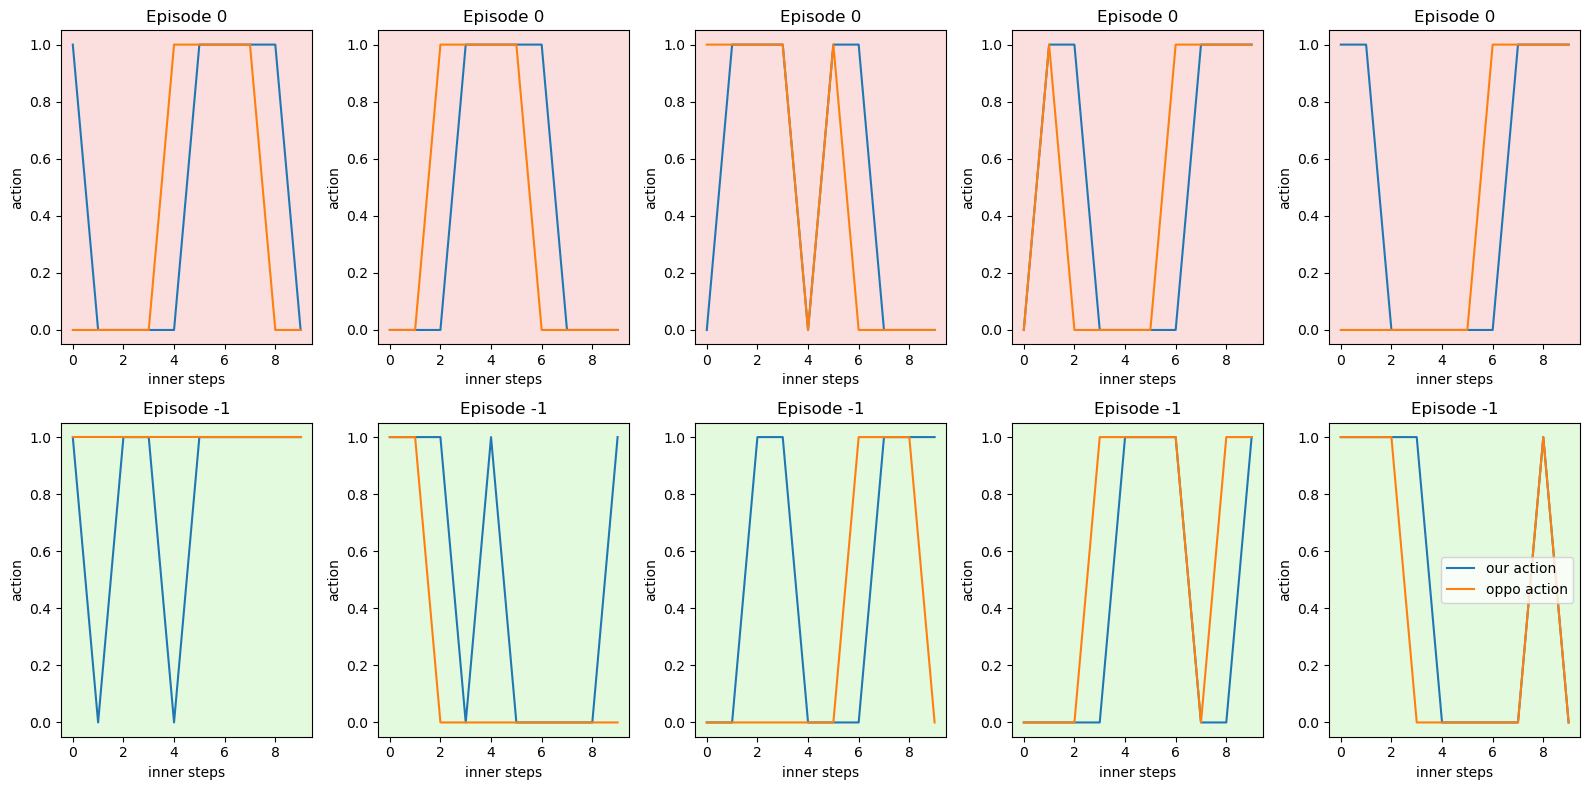

In [3]:
cols = ['Episode {}'.format(col) for col in [0,1,2,3,4, -5, -4, -3, -2, -1]]
rows = ["Action value", "Action value"]
fig, axs = plt.subplots(2, 5, figsize=(16, 8))
plt.setp(axs.flat, xlabel='inner steps', ylabel='action')

for j in range(5):
    axs[0,j].plot(act_forplot[0,j,:,0], label='our action')
    axs[0,j].plot(act_forplot[0,j,:,1], label='oppo action')
    axs[0,j].set_facecolor(row_color[0])
    axs[1,j-5].plot(act_forplot[0,j-5,:,0], label='our action')
    axs[1,j-5].plot(act_forplot[0,j-5,:,1], label='oppo action')
    axs[1,j-5].set_facecolor(row_color[1])
    axs[0,j].set_title(cols[0])
    axs[1,j-5].set_title(cols[-1])   

#for ax, row in zip(axs, rows):
#    ax.set_ylabel(row, rotation='vertical', size='large')
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
cols = ['Episode {}'.format(col) for col in [0,1,2,3,4, -5, -4, -3, -2, -1]]
rows = ["Cumulative reward", "Cumulative reward"]

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

plt.setp(axs.flat, xlabel='inner steps', ylabel='reward')

#for j in range(1):
axs[0].plot(np.cumsum(plot_rew[1][1,:,0]), label='our reward')
axs[0].plot(np.cumsum(plot_rew[1][1,:,1]), label='oppo reward')
axs[1].plot(np.cumsum(plot_rew[1][-1,:,0]), label='our reward')
axs[1].plot(np.cumsum(plot_rew[1][-1,:,1]), label='oppo reward')
axs[0].set_facecolor(row_color[0])
axs[0].set_title(cols[0])
axs[1].set_facecolor(row_color[1])
axs[1].set_title(cols[-1])

for ax, row in zip(axs, rows):
    ax.set_ylabel(row, rotation='vertical', size='large')

fig.tight_layout()
plt.legend()
plt.show()

# Plots


In [ ]:
datax = [4**2, 4**3, 4**4]
datay = [11 * 16**2 ,14 * 16**3, 13 * 16**4]
plt.xlabel('meta-state space size')
plt.ylabel('sample complexity/ number of episodes')
plt.scatter(datax, datay, label= "Empirical data on the number of episodes to reach convergenece")

x = np.linspace(0, 300, 300)
y = 12* x**2
plt.plot(x,y, 'orange', label="Theoretical sample complexity ~ O(x²)")
#plt.title("Empirical and theoretical sample complexity against meta-state space size for \u03B5 = 0.8")
plt.legend(bbox_to_anchor=(0.97, 1.2), prop={'size': 9})

In [ ]:
#generate histogram
visit_dict = {}
for i in range(len(rmax.nSA[0].flatten().tolist())):
    visit_dict[i]= rmax.nSA[0].flatten().tolist()[i]
    
histogram_dict = Counter(visit_dict.values())
plt.bar(histogram_dict.keys(), histogram_dict.values(), 0.5, color='g')
plt.xlabel("visitation counts: " + str(histogram_dict), fontsize=12)
figure0 = plt.gcf()
figure0.set_size_inches(10, 8)
#plt.savefig('histogram at' + str(datetime.now()) + '.png')

In [ ]:
y_2= np.divide(plot_visit_2[:,0], plot_visit_2[:,1], out=np.zeros_like(plot_visit_2[:,0]), where=plot_visit_2[:,1]!=0)
plt.plot(y_2, label='2 timesteps', lw=2)
plt.xlabel("m-visited state-action pairs out of " + str(rmax.ns * rmax.na))
plt.ylabel("Mean rewards")
plt.legend()

plt.show()

mean_2 = np.mean(plot_rew_2[:,:,0], axis=1)
convolve_2 = np.convolve(mean_2, np.ones(int((len(plot_rew_2)/10))) / (len(plot_rew_2)/10), mode='valid')

plt.plot(convolve_2, label="2 timesteps", lw=2)

#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew_2[:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew_2[:,:,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + 
          "\n hist_step= " + str(hist_step)+ " epsilon=" + str(epsilon) +
          "\n % of visited states= " + str((rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[0] * rmax.nSA.shape[1])))
plt.ylabel("Mean rewards")

plt.legend()
plt.show()

In [ ]:
y_3= np.divide(plot_visit_3[:,0], plot_visit_3[:,1], out=np.zeros_like(plot_visit_3[:,0]), where=plot_visit_3[:,1]!=0)
plt.plot(y_3, label='3 timesteps', lw=2)
plt.xlabel("m-visited state-action pairs out of " + str(rmax.ns * rmax.na))
plt.ylabel("Mean rewards")
plt.legend()

plt.show()

mean_3 = np.mean(plot_rew_3[:,:,0], axis=1)
convolve_3 = np.convolve(mean_3, np.ones(int((len(plot_rew_3)/10))) / (len(plot_rew_3)/10), mode='valid')

plt.plot(convolve_3, label="3 timesteps", lw=2)

#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew_3[:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew_3[:,:,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + 
          "\n hist_step= " + str(hist_step)+ " epsilon=" + str(epsilon) +
          "\n % of visited states= " + str((rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[0] * rmax.nSA.shape[1])))
plt.ylabel("Mean rewards")

plt.legend()
plt.show()

In [ ]:
y_4= np.divide(plot_visit_4[:,0], plot_visit_4[:,1], out=np.zeros_like(plot_visit_4[:,0]), where=plot_visit_4[:,1]!=0)
plt.plot(y_4, label='4 timesteps', lw=2)
plt.xlabel("m-visited state-action pairs out of " + str(rmax.ns * rmax.na))
plt.ylabel("Mean rewards")
plt.legend()
plt.show()

mean_4 = np.mean(plot_rew_4[:,:,0], axis=1)
convolve_4 = np.convolve(mean_4, np.ones(int((len(plot_rew_4)/10))) / (len(plot_rew_4)/10), mode='valid')

plt.plot(convolve_4, label="4 timesteps", lw=2)

#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew_4[:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew_4[:,:,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + 
          "\n hist_step= " + str(hist_step)+ " epsilon=" + str(epsilon) +
          "\n % of visited states= " + str((rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[0] * rmax.nSA.shape[1])))
plt.ylabel("Mean rewards")

plt.legend()
plt.show()

In [ ]:
#Visitation vs Reward curve
y_2= np.divide(plot_visit_2[:,0], plot_visit_2[:,1], out=np.zeros_like(plot_visit_2[:,0]), where=plot_visit_2[:,1]!=0)
y_3= np.divide(plot_visit_3[:,0], plot_visit_3[:,1], out=np.zeros_like(plot_visit_3[:,0]), where=plot_visit_3[:,1]!=0)
y_4= np.divide(plot_visit_4[:,0], plot_visit_4[:,1], out=np.zeros_like(plot_visit_4[:,0]), where=plot_visit_4[:,1]!=0)

plt.plot(y_2, label='2 timesteps', lw=2)
plt.plot(y_3, label='3 timesteps',lw=2)
plt.plot(y_4, label='4 timesteps', lw=2)

plt.xlabel("m-visited state-action pairs out of " + str(rmax.ns * rmax.na))
plt.ylabel("Mean rewards")
plt.legend()

plt.show()
#figure2 = plt.gcf() # get current figure
#figure2.set_size_inches(10, 8)


In [ ]:
#MA(metaepi/10)reward 
mean_2 = np.mean(plot_rew_2[:,:,0], axis=1)
convolve_2 = np.convolve(mean_2, np.ones(int((len(plot_rew_2)/10))) / (len(plot_rew_2)/10), mode='valid')

mean_3 = np.mean(plot_rew_3[:,:,0], axis=1)
convolve_3 = np.convolve(mean_3, np.ones(int((len(plot_rew_3)/10))) / (len(plot_rew_3)/10), mode='valid')

mean_4 = np.mean(plot_rew_4[:,:,0], axis=1)
convolve_4 = np.convolve(mean_4, np.ones(int((len(plot_rew_4)/10))) / (len(plot_rew_4)/10), mode='valid')

plt.plot(convolve_2, label="2 timesteps", lw=2)
plt.plot(convolve_3, label="3 timesteps",lw=2)
plt.plot(convolve_4, label="4 timesteps", lw=2)

#reward at batch 0 only
plt.xlabel("episodes \n Average reward of our agent: " + str(np.mean(plot_rew[:,:,0])) + 
          "\n Average reward of another agent: " + str(np.mean(plot_rew[:,:,1]))+
          "\n meta-episode= "+ str(meta_epi) + " meta_steps= " + str(meta_steps) + " meta_gamma= " + str(meta_gamma) + 
          "\n hist_step= " + str(hist_step)+ " epsilon=" + str(epsilon) +
          "\n % of visited states= " + str((rmax.nSA >= rmax.m).sum() / (rmax.nSA.shape[0] * rmax.nSA.shape[1])))
plt.ylabel("Mean rewards")

plt.legend()
plt.show()

#figure3 = plt.gcf() # get current figure
#figure3.set_size_inches(10, 8)


# Interpreting results

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.special import softmax
import random
import pickle
from datetime import datetime
from collections import Counter

with open('convolve2epsilon0.2.pkl', 'rb') as f:
    convolve_4 = pickle.load(f)

with open('convolve1epsilon0.2.pkl', 'rb') as f:
    convolve_3 = pickle.load(f)
    
with open('convolve0epsilon0.2.pkl', 'rb') as f:
    convolve_2 = pickle.load(f)
    
convolve_2 = convolve_2[0]
convolve_3 = convolve_3[1]
convolve_4 = convolve_4[-1]

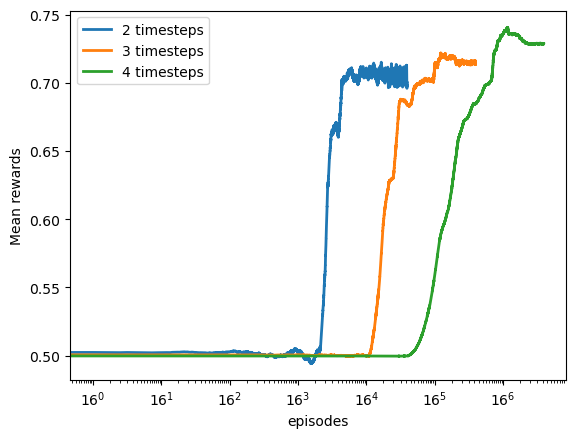

<Figure size 640x480 with 0 Axes>

In [40]:
plt.plot(convolve_2, label="2 timesteps", lw=2, markevery=3)
plt.plot(convolve_3, label="3 timesteps",lw=2, markevery=3)
xaxis = np.linspace(0,87017104,87017104)
plt.plot(xaxis[0:16**4], convolve_4[0:16**4], '#2ca02c', label="4 timesteps", lw=2, markevery=3)
plt.plot(xaxis[16**4:87017104], convolve_4[16**4:87017104],'#2ca02c', lw=2, markevery=500)

#reward at batch 0 only
plt.xlabel("episodes")
plt.xscale('log',base=16) 
plt.ylabel("Mean rewards")
plt.legend()
plt.show()

plt.savefig('visition_eps0.2.png', bbox_inches='tight')